# Integrating SC and ST data in human liver dataset

In this section, we present the basic evaluation for `stSCI` for integrating SC and ST data.

In [1]:
import stSCI
import scanpy as sc
from sklearn.metrics import davies_bouldin_score
from stSCI.utils.metrics import seurat_alignment_score

## Data preprocessing

First, we load the `.h5ad` file, then normalize and log-transform the raw gene expression data. 
For the SC data, we select one tumor core region at a time for integration (tumor core T1 for this script), aligning with the ST data from normal human liver.

In [2]:
sc_adata = sc.read('data/liver/sc_liver_multi_region.h5ad')
sc_adata = sc_adata['Tumor core T1' == sc_adata.obs['region']]
sc_adata.var_names_make_unique()
sc.pp.normalize_total(sc_adata, target_sum=1e4)
sc.pp.log1p(sc_adata)

In [3]:
st_adata = sc.read_visium('data/liver/st_l5')
st_adata.obs['cluster'] = 'ST'
st_adata.var_names_make_unique()
sc.pp.normalize_total(st_adata, target_sum=1e4)
sc.pp.log1p(st_adata)

## Model training

Next, we train the `stSCI` model by the `stSCI.train()` function. To enable reproducibility of the results, users can specify a save path for the model parameter file.

In [4]:
sc_adata, st_adata = stSCI.train(sc_adata, st_adata, model_save_path='model_paras/integration/human_liver/tumor_core_t1.pt')

>>> INFO: Filtered 272 genes.
>>> INFO: Find 2728 same HVGs, result data shapes: [(19457, 2728), (4177, 2728)].
>>> INFO: Generate 29239 edges, 6.000 edges per spot (0.01s).
>>> INFO: Finish PCA (1.52s).
>>> INFO: Finish centroid generation (1.92s).
>>> INFO: Finish centroid generation (0.13s).


>>> Train stSCI: 100%|██████████| 500/500 [00:34<00:00, 14.46it/s]


>>> INFO: Train stSCI model (46.41s).


## Evaluation

We can evaluate the model performance by the DB and SAS score as follows. Specifically, the implementation of the SAS in Python can be found at [GLUE](https://github.com/gao-lab/GLUE/blob/v0.2.2/scglue/metrics.py).

In [5]:
concat_adata = sc.concat((sc_adata, st_adata), label='batch', keys=['SC', 'ST'])
sc.pp.neighbors(concat_adata, use_rep='embedding')
sc.tl.louvain(concat_adata, resolution=0.8)
db_score = davies_bouldin_score(concat_adata.obsm['embedding'], concat_adata.obs['louvain'])
sas_score = seurat_alignment_score(concat_adata.obsm['embedding'], concat_adata.obs['batch'].to_numpy())
print(f'>>> 1/DB (biology conservation) score: {1/db_score:.3f}, SAS (omics mixture) score: {sas_score.mean():.3f}')

>>> 1/DB (biology conservation) score: 0.817, SAS (omics mixture) score: 0.698


## UMAP visualization

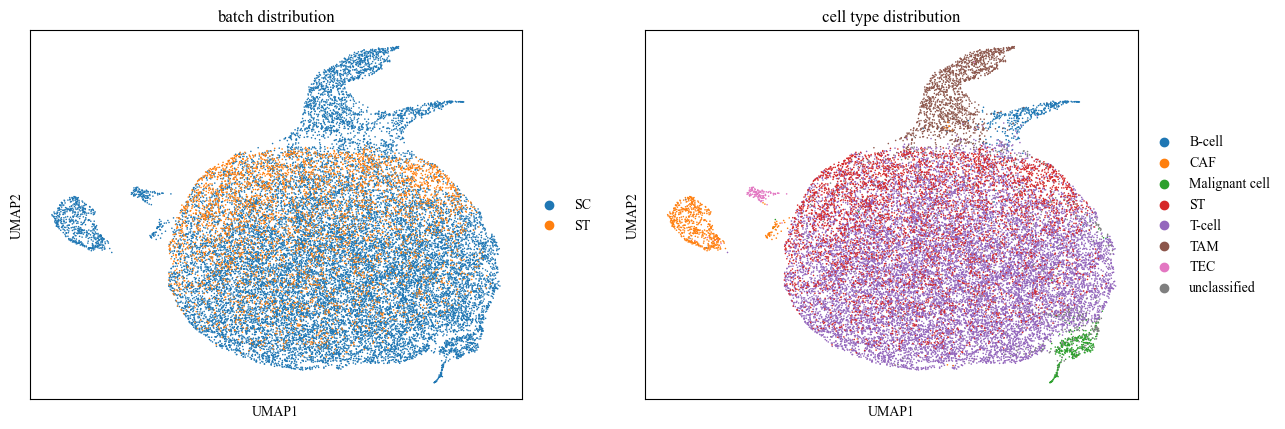

In [6]:
sc.pp.neighbors(concat_adata, use_rep='embedding')
sc.tl.umap(concat_adata)
sc.pl.umap(concat_adata, color=['batch', 'cluster'], title=['batch distribution', 'cell type distribution'])